## Part 2a) Assigment

In [ ]:
import torch
from torch import nn, Tensor
import numpy as np
import random
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import v2 as transforms_v2
from torchvision.transforms import ToTensor
from torchvision.io import decode_image
import torch.optim.lr_scheduler as lr_scheduler
import os
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional
import time
from PIL import Image

In [47]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using {device} device")

Using mps device


In [48]:

dataset_paths = ["/Users/leonardomassaro/Desktop/DatasetOxford_prof/", "/scratch.hpc/leomass/ipcv-assignment-2/dataset/", "/scratch.hpc/leonardo.massaro2/ipcv-assignment-2/dataset/"]
correct_path = None

for path in dataset_paths:
    if os.path.exists(path) and os.path.isdir(path):
        print("Detected dataset on ", path)
        correct_path = path
if not correct_path:
    raise Exception("No dataset found")

Detected dataset on  /Users/leonardomassaro/Desktop/DatasetOxford_prof/


In [49]:
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)

In [50]:
class OxfordPetDataset(Dataset):
    def __init__(self, path, file_name, transform=None) -> None:
        super().__init__()
        self.filename = file_name
        self.root = Path(path)
        self.transform = transform
        self.names, self.labels = self._get_names_and_labels()
        tot_size_bytes = 0
        n_images = 0
        loaded_data = []
        idx = 0
        while idx < len(self.names):
            name = self.names[idx]
            img_tensor = self.get_img_from_filesystem(name)
            tot_size_bytes += img_tensor.numel() * img_tensor.element_size()
            n_images += 1
            loaded_data.append(img_tensor)
            idx += 1
        print("tot size", tot_size_bytes, "bytes, for", n_images, "images")
        self.data_tensor = torch.stack(loaded_data).to(device=device)
        self.labels = torch.Tensor(self.labels).type(torch.LongTensor).to(device=device)
        
    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:

        label = self.labels[idx]
        img = self.data_tensor[idx]
        img = self.transform(img).to(device)

        return img, label
    
    def get_img_from_filesystem(self, name) -> Tensor:
        img_path = self.root / "images" / f"{name}.jpg"
        #img = decode_image(img_path).to(torch.float)
        img = Image.open(img_path).convert("RGB")
        img = transforms.Resize((256,256))(img)
        img = transforms.ToTensor()(img)
        return img


    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / self.filename) as f:
            for line in f:
                if(line[0] == "#"):
                    continue
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

In [ ]:
BATCH_SIZE = 64
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

training_transform_stack = transforms_v2.Compose([
    transforms_v2.RandomResizedCrop(size=(224, 224)),
    transforms_v2.RandomHorizontalFlip(p=0.5),
    transforms_v2.ToDtype(torch.float32, scale=True),
    transforms_v2.Normalize(mean=MEAN,
                   std=STD),
])

testing_transform_stack = transforms_v2.Compose([
    transforms_v2.Resize(256),
    transforms_v2.CenterCrop(224),
    transforms_v2.Normalize(MEAN, STD)
])

'''
training_transform_stack = transforms.Compose([
    transforms.ToPILImage(),
    transforms.TrivialAugmentWide(),
    transforms.RandomRotation(degrees=(0,270)),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

testing_transform_stack = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(MEAN, STD)
])
'''

train_dataset = OxfordPetDataset(correct_path, file_name="train.txt" , transform=training_transform_stack)
test_dataset = OxfordPetDataset(correct_path, file_name="test.txt" , transform=testing_transform_stack)


# Create data loaders.
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#validation_dataloader = DataLoader(validation_ds, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

tot size 90439680 bytes, for 115 images
tot size 36175872 bytes, for 46 images
Shape of X [N, C, H, W]: torch.Size([46, 3, 224, 224])
Shape of y: torch.Size([46]) torch.int64


In [52]:

# Defining custom Dense Block
class DenseBlock(nn.Module):
    def __init__(self, num_convs:int, growth_rate:int, has_transition:bool):
        super(DenseBlock, self).__init__()
        self.num_convs = num_convs
        self.growth_rate = growth_rate
        layer = []
        for i in range(num_convs):
            layer.append(self.conv_block(growth_rate))
        self.dense_net = nn.Sequential(*layer)
        self.transition_net = self.transition_block() if has_transition else None

    def conv_block(self, num_channels):
        return (
            nn.Sequential(
                nn.LazyBatchNorm2d(),
                nn.ReLU(),
                nn.LazyConv2d(num_channels, 3, padding=1))
        )
    
    def transition_block(self): #transition block to reduce channel dimensionality (conv has to be 1x1)
        compression_factor = 0.5
        num_transition_channels = int(compression_factor * (self.growth_rate * self.num_convs))
        return (
            nn.Sequential(
                nn.LazyBatchNorm2d(),
                nn.ReLU(),
                nn.LazyConv2d(num_transition_channels, 1),
                nn.AvgPool2d(2, stride=2)
                )
        )

    def forward(self, X):
        # In the Dense block, every layer has in input the concatenation of all the previous ones
        for block in self.dense_net:
            last_out = block(X)
            X = torch.cat((X, last_out), dim=1)
        if self.transition_net != None:
            X = self.transition_net(X)
        return X

In [53]:

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, num_dense_blocks, num_conv_each_dense, growth_rate):
        super().__init__()
        stem_block = [ #initial stem block, like resnet
            nn.LazyConv2d(32, 7, stride=2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
        ]

        dense_core = [
            DenseBlock(num_convs=num_conv_each_dense[i], growth_rate=growth_rate, has_transition= True ) for i in range(num_dense_blocks)
        ]

        classification_block = [
            nn.LazyBatchNorm2d(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.LazyLinear(37)
        ]

        self.net_stack = nn.Sequential(*stem_block, *dense_core, *classification_block)

    def forward(self, x):
        result = self.net_stack(x)
        return result

#model = NeuralNetwork(num_dense_blocks=3, num_conv_each_dense=[6,16,14], growth_rate=12).to(device)
model = NeuralNetwork(num_dense_blocks=1, num_conv_each_dense=[1,1,1], growth_rate=2).to(device)
print(model)

NeuralNetwork(
  (net_stack): Sequential(
    (0): LazyConv2d(0, 32, kernel_size=(7, 7), stride=(2, 2))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): DenseBlock(
      (dense_net): Sequential(
        (0): Sequential(
          (0): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): LazyConv2d(0, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (transition_net): Sequential(
        (0): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): LazyConv2d(0, 1, kernel_size=(1, 1), stride=(1, 1))
        (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
    )
    (5): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): AdaptiveAvgPool

In [54]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

warmup_scheduler = lr_scheduler.LinearLR(optimizer, start_factor=0.01, end_factor=1.0, total_iters=5800)
main_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=15)


In [55]:
batch_lrs = []           # record learning rate per batch
epoch_end_indices = []   # store index (batch count) at the end of each epoch

In [56]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0.0
    num_batches = 0

    for X, y in dataloader:
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        warmup_scheduler.step()

        total_loss += loss.item()
        num_batches += 1
        batch_lrs.append(optimizer.param_groups[0]["lr"])

    avg_loss = total_loss / num_batches
    return avg_loss

In [57]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    accuracy = 100*correct
    return accuracy, test_loss
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

from torchinfo import summary

summary(model, input_size=(64, 3, 256, 256))

In [ ]:
epochs = 150

net_performance_data = {
    "train_loss": [],
    "test_loss": [],
    "test_accuracy": []
}

t1 = time.time()

for t in range(epochs):
    net_performance_data["train_loss"].append( train(train_dataloader, model, loss_fn, optimizer) )
    test_accuracy, test_loss = test(test_dataloader, model, loss_fn)
    if t > 70: main_scheduler.step(test_accuracy)
    net_performance_data["test_loss"].append( test_loss )
    net_performance_data["test_accuracy"].append( test_accuracy )
    epoch_end_indices.append(len(batch_lrs))

t2 = time.time()

print("Done in ", t2-t1, " sec")

Done in  13.41089391708374  sec


In [59]:
net_performance_data_df = pd.DataFrame(data=net_performance_data)

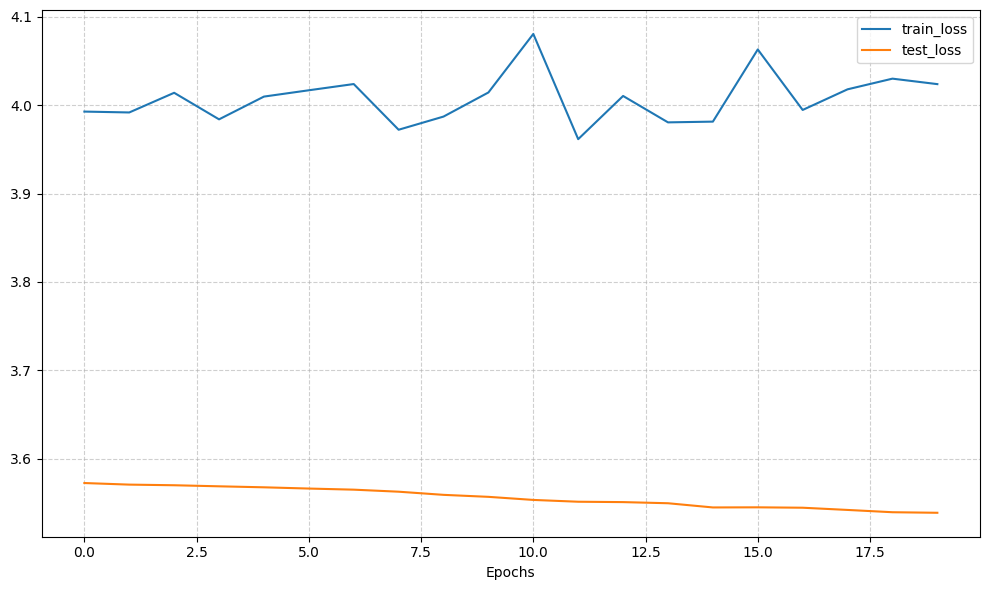

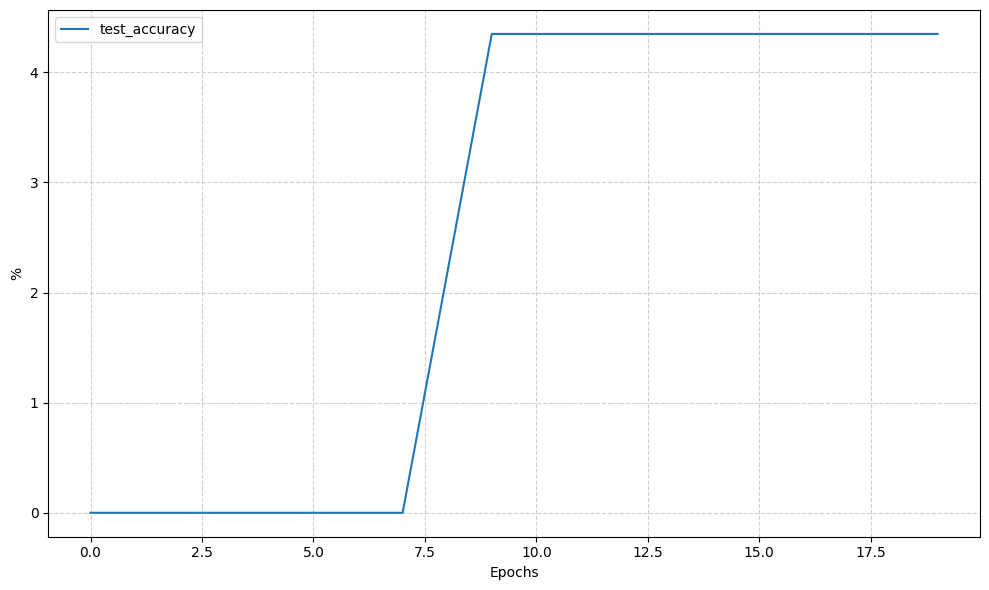

In [60]:
plt.figure(figsize=(10, 6))

plt.plot(net_performance_data_df.index, net_performance_data_df["train_loss"], label="train_loss")
plt.plot(net_performance_data_df.index, net_performance_data_df["test_loss"], label="test_loss")

plt.xlabel('Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

plt.plot(net_performance_data_df.index, net_performance_data_df["test_accuracy"], label="test_accuracy")

plt.xlabel('Epochs')
plt.ylabel('%')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

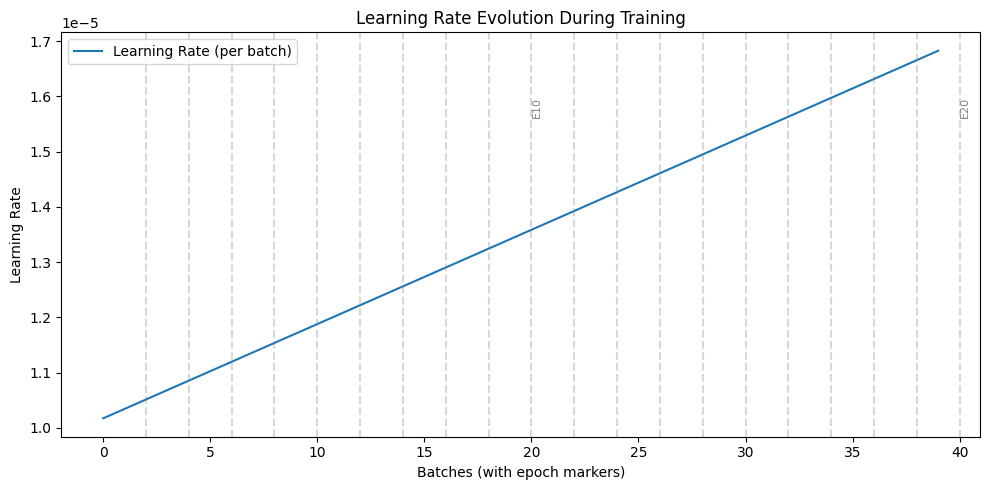

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(batch_lrs, label="Learning Rate (per batch)")

# Add vertical lines to mark epoch boundaries
for i, idx in enumerate(epoch_end_indices):
    plt.axvline(x=idx, color='gray', linestyle='--', alpha=0.3)
    # Label every 10th epoch to avoid clutter
    if (i + 1) % 10 == 0:
        plt.text(idx, max(batch_lrs)*0.95, f'E{i+1}', rotation=90, fontsize=8, color='gray', va='top')

plt.xlabel("Batches (with epoch markers)")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Evolution During Training")
plt.legend()
plt.tight_layout()
plt.show()